## 1. Load & Inspect EGG/MEG Data

**Goal:** Learn how to load raw EEG/MEG data into MNE-Python, explore its structure, and perform basic visualization.

**Concepts Covered:**
- Raw EEG/MEG data structure
- Channels and channel types
- Sampling frequency
- Event/stimulus channels
- Basic visualization of time series and power spectral density

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import shutil

### Loading MNE sample EEG/MEG data
The sample dataset includes both MEG and EEG data collected while a subject performed an audiovisual experiment, along with structural MRI scans.


In [2]:
notebook_dir = Path.cwd()

data_dir = notebook_dir.parent / "data"
data_dir.mkdir(exist_ok=True)

print("Downloading MNE sample dataset...")
data_path = mne.datasets.sample.data_path(verbose=True)

raw_src = data_path / 'MEG' / 'sample' / 'sample_audvis_raw.fif'
raw_dest = data_dir / 'sample_audvis_raw.fif'

if not raw_dest.exists():
    shutil.copy(raw_src, raw_dest)
    print(f"Copied to: {raw_dest}")
else:
    print(f"File already exists at: {raw_dest}")

# 'read_raw_fif' loads continuous (unprocessed) data into a Raw object.
# Setting preload=True loads the data into memory so we can manipulate it.
raw = mne.io.read_raw_fif(raw_dest, preload=True)

print(raw) # This shows general info: data shape, channel count, etc.

File already exists at: /Users/yibeisita/Documents/neuro-ai-playground/projects/01_eeg_meg_analysis/data/sample_audvis_raw.fif
Opening raw data file /Users/yibeisita/Documents/neuro-ai-playground/projects/01_eeg_meg_analysis/data/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
<Raw | sample_audvis_raw.fif, 376 x 166800 (277.7 s), ~481.7 MiB, data loaded>


### Inspect Metadata

`raw.info` contains detailed metadata about the recording:
- `sfreq` is the sampling frequency (samples per second)
- `ch_names` lists all channel names
- `n_times` is the total number of time points
- `raw.info['meas_date']` is the date and time of the recording

The sampling frequency tells you how many times per second the brain’s electrical activity was recorded. For example, 1000 Hz = 1000 samples/sec.

In [3]:
print("\n--- Info Metadata---")
print(raw.info)
print("Sampling Frequency:", raw.info['sfreq'], "Hz")
print("\nChannels:", len(raw.ch_names))
print("\nTimes:", raw.n_times)
print("\nMeas Date:", raw.info['meas_date'])



--- Info Metadata---
<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>
Sampling Frequency: 600.614990234375 Hz

Channels: 376

Times: 166800

Meas Date: 2002-12-03 19:01:10.720100+00:00


### Filter to EEG-only channels
This step selects only EEG (and EOG + stimulus) channels for simplicity.
- `EOG (electrooculogram)` channels track eye movements/blinks,
- `STI 014` is the stimulus trigger channel marking event onsets.

In [4]:
raw.pick_types(meg=False, eeg=True, eog=True, stim=True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Raw | sample_audvis_raw.fif, 69 x 166800 (277.7 s), ~90.8 MiB, data loaded>

### Plot Raw EGG Signals
- Each line corresponds to one electrode

**Note:**
- This plot uses the **Matplotlib backend** for compatibility with Jupyter Notebooks. 
- It shows EEG signals as a static 2D plot — scrolling and annotations are disabled.  
- For full interactivity (scrolling, marking bad channels, etc.), run this cell in a standalone Python script or environment with Qt support.

Using matplotlib as 2D backend.


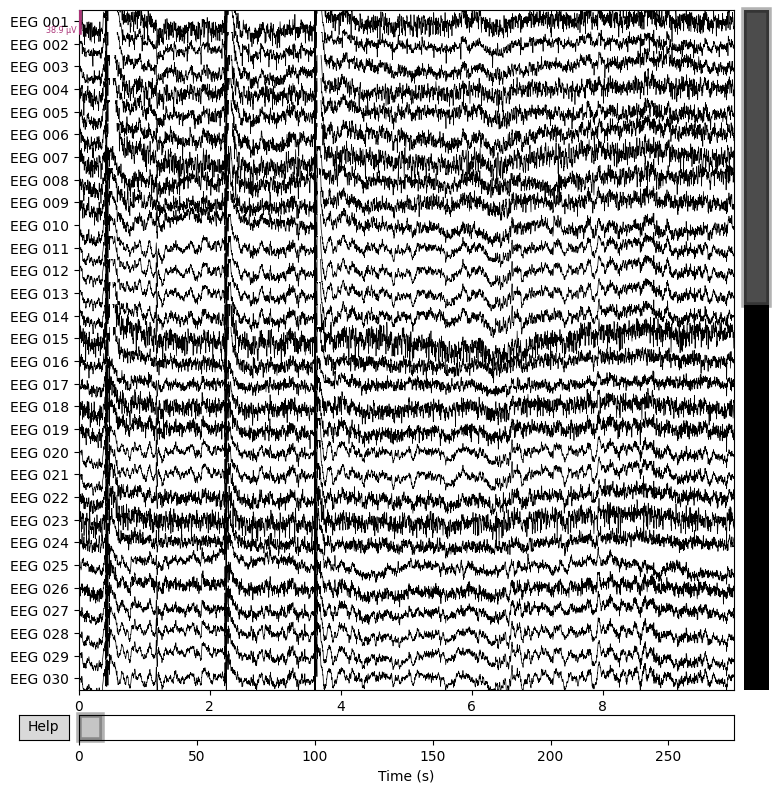

In [5]:
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib', set_env=True)
raw.plot(n_channels=30, scalings='auto', title='EEG Raw Data', show=False)
plt.show()

### Plot Power Spectral Density
- Shows how signal power is distributed across frequencies
- Helps identify dominant rhythms and noise (e.g., alpha, beta, line noise)

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_30030/1372297633.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_30030/1372297633.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


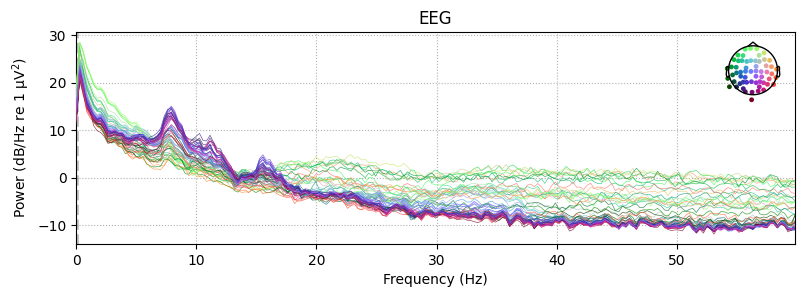

In [6]:
psd = raw.compute_psd(fmax=60)
fig = psd.plot(picks="data", exclude="bads", amplitude=False, show=False)

plt.tight_layout()
plt.show()

In [7]:
os.makedirs("../results", exist_ok=True)
fig.savefig("../results/psd_plot.png", dpi=150)

### Find & Visualize Events (Stimuli Markers)
Many EEG/MEG experiments present stimuli (sounds, images, etc.) and record their timing. These triggers are stored in a *stimulus channel*. Here, `STI 014`. Each "event" marks when something happened during the recording.

Each event is stored as a triplet: [sample_index, 0, event_code]
- `sample_index`: when it occurred in time (in samples)
- `event_code`: the stimulus identifier (e.g., 1 for "sound left ear", 2 for "right ear")

Finding events on: STI 014
320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


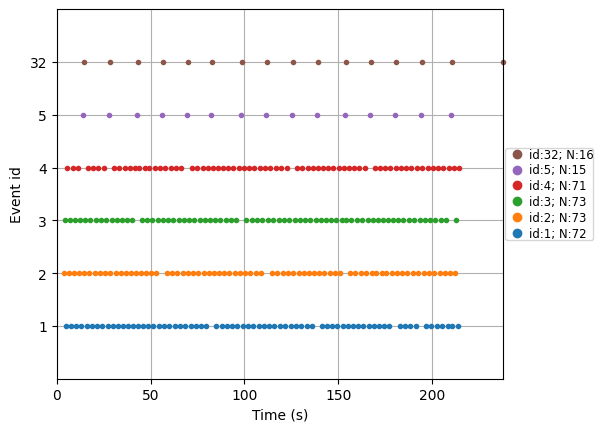

In [8]:
events = mne.find_events(raw, stim_channel='STI 014')

# 'sfreq' converts sample indices to time (in seconds)
# 'first_samp' adjusts for any offset if recording didn’t start at zero
fig1 = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, show=False)
plt.show()

In [9]:
os.makedirs("../results", exist_ok=True)
fig1.savefig("../results/sti_014_plot.png", dpi=150)